# Case 2 - FraudTransactions

- Jose Abal Caamaaño
- Jesús Platero Acevedo

In this case, we will study a dataset to determinate if it was produced fraud or not. In the first step we will do an **exploratory data analysis (EDA)**, secondary, we will do the **preprocessed of our dataset** and in last, will **create the models**. Once chosen the best, we will optimized it. 

# Index:

## 1. Libraries
## 2. Creation of the functions
## 3. Read and load the data and created the data frame of fraud
## 4. Division of our categorical and numerical variables
## 5. Duplicate values, missing values and outliers
 - Duplicated values
 - Missing values
 - Outliers
 
## 6. Verification of our variable target (isFraud)
## 7. Behaviour of our variables
 - Age
 - Type
 - Device
 - Zone
 
## 8. Study of Correlation
 - Correlation Matrix
 - Heatmap
 - Pearson
 
## 9. Save the created dataset
## 10. Conclusions

## 1. Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


Bad key text.latex.preview in file /Users/joseabalcaamano/opt/anaconda3/envs/machineLearning/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/joseabalcaamano/opt/anaconda3/envs/machineLearning/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/joseabalcaamano/opt/anaconda3/envs/machineLearning/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_cl

## 2. CREATION OF THE FUNCTIONS

In [2]:
#This function is to give support to do plots of the differents variables inside the dataset to compare our 
#target variable with the others

def plot_feature(df, col_name, isContinuous, target):
    """
    Visualize a variable with and without faceting on the loan status.
    - df dataframe
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    if isContinuous:
        
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)


    if isContinuous:
        sns.boxplot(x=col_name, y=target, data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by '+target)
    else:
        data = df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proportion').reset_index() 
        data.columns = [i, target, 'proportion']
        #sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        ax2.set_ylabel(target+' fraction')
        ax2.set_title(target)
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()
    
#This function is to identify the categorical variables and put it inside a list. With the numerical variables is
#the same form but in other list.
def give_categorical_variables(dataset=None):
    if dataset is None:
        print(u'\nNeed arguments in the function')
        return 1
    list_categorical_variables = []
    other = []
    for i in dataset.columns:
        if (dataset[i].dtype!=float) & (dataset[i].dtype!=int):
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 100:
                list_categorical_variables.append(i)
            else:
                other.append(i)

    return list_categorical_variables, other

def get_deviation_of_mean_perc(pd_data, list_numerical_variables, target, multiplier):
    """
    Return the percentage of the values out of the confidence interval 
    :type series:
    :param multiplier:
    :return:
    """
    pd_final = pd.DataFrame()
    
    for i in list_numerical_variables:
        
        series_mean = pd_data[i].mean()
        series_std = pd_data[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = pd_data[i].size
        
        perc_goods = pd_data[i][(pd_data[i] >= left) & (pd_data[i] <= right)].size/size_s
        perc_excess = pd_data[i][(pd_data[i] < left) | (pd_data[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(pd_data[target][(pd_data[i] < left) | (pd_data[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0:], 
                                          pd_concat_percent.iloc[0:]]
            pd_concat_percent = pd_concat_percent.drop('index',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = pd_data[i][(pd_data[i] < left) | (pd_data[i] > right)].size
            pd_concat_percent['porcentaje_sum_null_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('Not exists variables with null values')
        
    return pd_final


def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    #To obtain Spearman correlation 

    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo) 
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0


## 3. Read and load the data and created the data frame of fraud

In [3]:
ruta = '../data/raw/Copia de Original_dataset_payments_fraud.csv'
set_seed = '12345'

In [33]:
data = (pd.read_csv(ruta, sep = ';')
        .assign(**{'connection_time': lambda df: df['connection_time'].str.replace(',', '.').astype(float)})
)
data.head()

,step,type,amount,gender,device,connection_time,nameOrig,race,oldbalanceOrg,age,newbalanceOrig,zone,user_number,nameDest,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,man,mac,0.140039,C1231006815,black,170136.0,85,160296.36,capital,138,M1979787155,5,1,0.0,0.0,0
1,1,PAYMENT,1864.28,woman,mac,0.496890,C1666544295,asian,21249.0,57,19384.72,country,909,M2044282225,1,0,0.0,0.0,0
2,1,TRANSFER,181.00,man,pc,0.781150,C1305486145,asian,181.0,66,0.00,capital,2569,C553264065,10,0,0.0,0.0,1
3,1,CASH_OUT,181.00,man,mac,0.565068,C840083671,black,181.0,31,0.00,country,1787,C38997010,3,0,21182.0,0.0,1
4,1,PAYMENT,11668.14,unknow,mac,0.517114,C2048537720,black,41554.0,90,29885.86,country,3997,M1230701703,8,0,0.0,0.0,0


Our target variable is the last column, isFraud.

In [5]:
#Comprobate the rows and columns in our dataset 
data.shape

(1048575, 19)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   step              1048575 non-null  int64  
 1   type              1048575 non-null  object 
 2   amount            1048575 non-null  float64
 3   gender            943457 non-null   object 
 4   device            943995 non-null   object 
 5   connection_time   1048575 non-null  float64
 6   nameOrig          1048575 non-null  object 
 7   race              943412 non-null   object 
 8   oldbalanceOrg     1048575 non-null  float64
 9   age               1048575 non-null  int64  
 10  newbalanceOrig    1048575 non-null  float64
 11  zone              944161 non-null   object 
 12  user_number       1048575 non-null  int64  
 13  nameDest          1048575 non-null  object 
 14  user_connections  1048575 non-null  int64  
 15  security_alert    1048575 non-null  int64  
 16  

In [7]:
#Type of the variables in our dataset
data.dtypes.sort_values().to_frame("Type_variable").groupby(by="Type_variable").size().to_frame('count').reset_index()

,Type_variable,count
0,int64,6
1,float64,6
2,object,7


From all variables in our dataset, we can observe that exists **6 int variables**, **6 float variables** and **7 object variables**.

## 4. Division of our categorical and numerical variables

In [8]:
categorical_variables = data[["type", "device", "zone", 
                              "security_alert", "isFraud"]].astype(str).reset_index()

numerical_variables = data [["step", "amount", "connection_time", 
                             "oldbalanceOrg","age", "newbalanceOrig", "user_number", 
                             "user_connections", "oldbalanceDest", "newbalanceDest"]].astype(float).reset_index()

In [9]:
#We check if we made correctly the separation of the variables
categorical_variables.info()

numerical_variables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   index           1048575 non-null  int64 
 1   type            1048575 non-null  object
 2   device          1048575 non-null  object
 3   zone            1048575 non-null  object
 4   security_alert  1048575 non-null  object
 5   isFraud         1048575 non-null  object
dtypes: int64(1), object(5)
memory usage: 48.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   index             1048575 non-null  int64  
 1   step              1048575 non-null  float64
 2   amount            1048575 non-null  float64
 3   connection_time   1048575 non-null  float64
 4   oldbalanceOrg     1048575 non-null  float64
 5   age     

In [10]:
#Visualization the list with the variables modificated
list_categorical_variables, other = give_categorical_variables(dataset = data)
data[list_categorical_variables] = data[list_categorical_variables].astype("category")
list_numerical_variables = list(data.select_dtypes("float").columns)
data[list_numerical_variables] = data[list_numerical_variables].astype(float)
data.dtypes

step                   int64
type                category
amount               float64
gender              category
device              category
connection_time      float64
nameOrig              object
race                category
oldbalanceOrg        float64
age                    int64
newbalanceOrig       float64
zone                category
user_number            int64
nameDest              object
user_connections       int64
security_alert         int64
oldbalanceDest       float64
newbalanceDest       float64
isFraud                int64
dtype: object

## 5. Duplicate values, missing values and outliers

### -Duplicated Values

In [11]:
#Observe if there are duplicates in our dataset 
print(data.shape, data.drop_duplicates().shape)
data.duplicated().sum()

(1048575, 19) (1048575, 19)


0

After the comprobation, we haven´t exists **duplicated values** in our dataset.

### -Missing Values 

In [12]:
#Comprobate if in our dataframe exists nulls values
data_null_columns = data.isnull().sum().sort_values(ascending=False)
data_null_rows = data.isnull().sum(axis=1).sort_values(ascending=False)
print(data_null_columns.shape, data_null_rows.shape)

df_null_columns = pd.DataFrame(data_null_columns, columns=['nulls_columns'])     
df_null_rows = pd.DataFrame(data_null_rows, columns=['nulls_rows'])  
df_null_columns['percent_columns'] = df_null_columns['nulls_columns']/data.shape[0]
df_null_rows['percent_rows']= df_null_rows['nulls_rows']/data.shape[1]

(19,) (1048575,)


In [13]:
df_null_columns

,nulls_columns,percent_columns
race,105163,0.100291
gender,105118,0.100248
device,104580,0.099735
zone,104414,0.099577
step,0,0.000000
newbalanceDest,0,0.000000
oldbalanceDest,0,0.000000
security_alert,0,0.000000
user_connections,0,0.000000
nameDest,0,0.000000


We can observate that **exists missing values** in the columns **race**, **gender**, **device** and **zone**.

In [14]:
#Verification the rows with nulls
df_null_rows.head()

,nulls_rows,percent_rows
89367,4,0.210526
574234,4,0.210526
201502,4,0.210526
927846,4,0.210526
556042,4,0.210526


### -Outliers 

In [15]:
get_deviation_of_mean_perc(data, list_numerical_variables, target='isFraud', multiplier = 2)

,0,1,variable,sum_outlier_values,porcentaje_sum_null_values
,0,1,,,
0,0.986908,0.013092,amount,32081,0.030595
1,0.998938,0.001062,oldbalanceOrg,45203,0.043109
2,0.999934,0.000066,newbalanceOrig,45698,0.043581
3,0.999480,0.000520,oldbalanceDest,40402,0.038530
4,0.998491,0.001509,newbalanceDest,41751,0.039817


## 6. Verification of our variable target (isFraud)

In [16]:
# Verificamos el comportamiento de la variable objetivo dentro de nuestro dataset para identificar como se procederan a 
# dividir el set de datos de training y el de test
data_percentage=data.isFraud.value_counts(normalize=True).rename("percentage").mul(100).reset_index().round(2)
data_quantity=data.isFraud.value_counts().rename("quantity").reset_index()

data_isFraud=pd.merge(data_percentage, data_quantity, how= "inner", on=["index"])
data_isFraud=pd.DataFrame(data_isFraud)
data_isFraud

,index,percentage,quantity
0,0,99.89,1047433
1,1,0.11,1142


Text(0.5, 1.05, 'Distribution Target Variable')

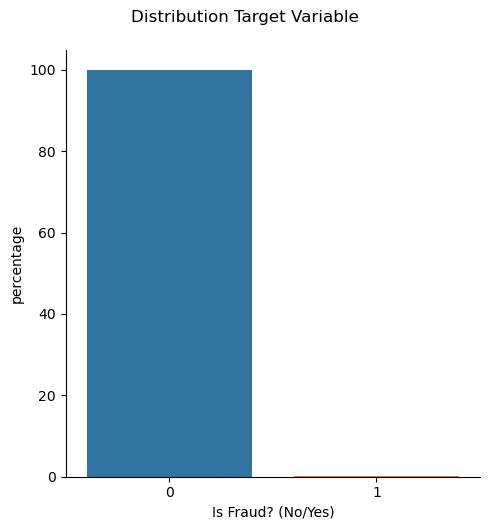

In [17]:
graph=sns.catplot(data=data_isFraud, x="index", y="percentage", kind="bar")
graph.set(xlabel="Is Fraud? (No/Yes)")
graph.fig.suptitle("Distribution Target Variable", y=1.05)

In the created plot, 0 represented the times that a transaction it was not a fraud and 1 the times that was fraud.
The dataset is completely unbalanced, since our target variable isFraud, being the not fraud variables in the 99.89% of the cases.

## 7. Behaviour of our variables

Verification of the behaviour of our variables and compare them with the target variable. 

### -Age 

Text(0.5, 1.0, 'Behaviour of the variable age in relationship with Fraud')

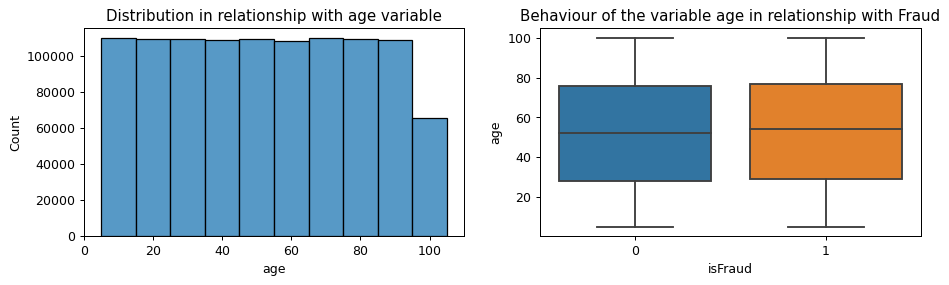

In [18]:
# Analisis de la variable de edad
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.histplot(data=data, x='age', binwidth=10, ax=ax1)
sns.boxplot(x='isFraud', y='age', data=data, ax=ax2,)
ax1.set_title("Distribution in relationship with age variable")
ax2.set_title("Behaviour of the variable age in relationship with Fraud")

In [19]:
data.age.groupby(data.age).count().to_frame().head(5)

,age
age,
5,11055
6,10843
7,11088
8,10980
9,10830


The age not represented more impact with our target variable. 

### -Type

Text(0.5, 1.0, 'Behaviour of the variable type in relationship with Fraud')

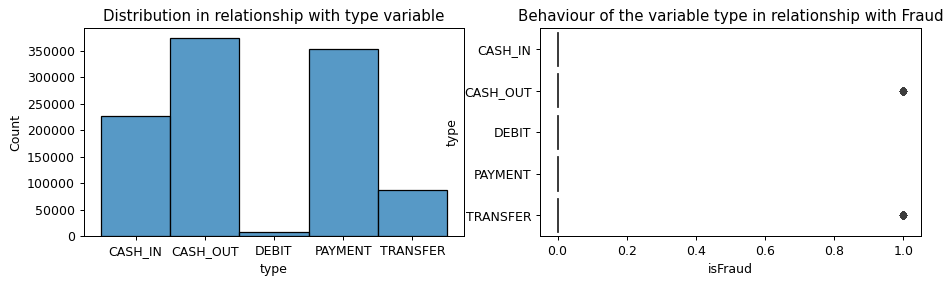

In [20]:
# Analisis de la variable de type
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.histplot(data=data, x='type', binwidth=10, ax=ax1)
sns.boxplot(x='isFraud', y='type', data=data, ax=ax2,)
ax1.set_title("Distribution in relationship with type variable")
ax2.set_title("Behaviour of the variable type in relationship with Fraud")

In [21]:
data_noFraud=data.loc[(data['isFraud'] == 0),['isFraud','type']].groupby('type').count().reset_index().set_axis(["type","noFraud"],axis=1)
data_yesFraud=data.loc[(data['isFraud'] == 1),['isFraud','type']].groupby('type').count().reset_index().set_axis(["type","yesFraud"],axis=1)
type(data_noFraud)
data_Fraud_type=pd.merge(data_noFraud,data_yesFraud, how= "left", on=["type"])
data_Fraud_type

,type,noFraud,yesFraud
0,CASH_IN,227130,0
1,CASH_OUT,373063,578
2,DEBIT,7178,0
3,PAYMENT,353873,0
4,TRANSFER,86189,564


Only the transactions "cash_out" and "transfer" are those that were classified as fraud, the other types of transactions were not fraudulent. This variable has an important impact on the fraud.

### -Device 

Text(0.5, 1.0, 'Behaviour of the variable device in relationship with Fraud')

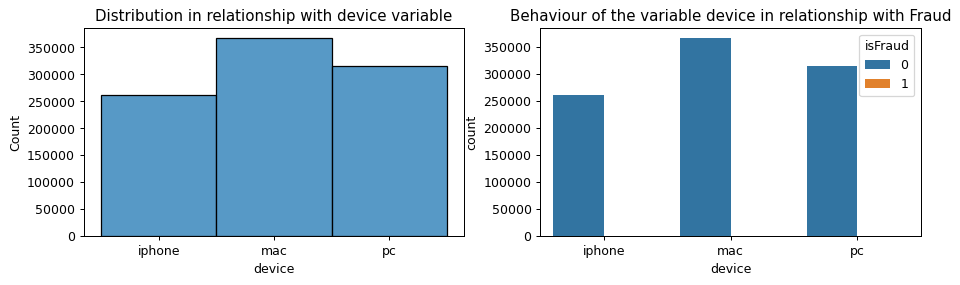

In [22]:
# Analysis of the variable device
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.histplot(data=data, x='device', ax=ax1, stat='count')
sns.countplot(x='device', data=data, hue='isFraud', ax=ax2)
ax1.set_title("Distribution in relationship with device variable")
ax2.set_title("Behaviour of the variable device in relationship with Fraud")

In [23]:
data_noFraud=data.loc[(data['isFraud'] == 0),['isFraud','device']].groupby('device').count().reset_index().set_axis(["device","noFraud"],axis=1)
data_yesFraud=data.loc[(data['isFraud'] == 1),['isFraud','device']].groupby('device').count().reset_index().set_axis(["device","yesFraud"],axis=1)
data_Fraud_device=pd.merge(data_noFraud,data_yesFraud, how= "inner", on=["device"])
data_Fraud_device

,device,noFraud,yesFraud
0,iphone,261767,295
1,mac,366677,389
2,pc,314528,339


The table created shows that there isn´t much difference between the devices where the transaction was made and whether the type of transaction was fraud or not.

### -Zone

Text(0.5, 1.0, 'Behaviour of the variable zone in relationship with Fraud')

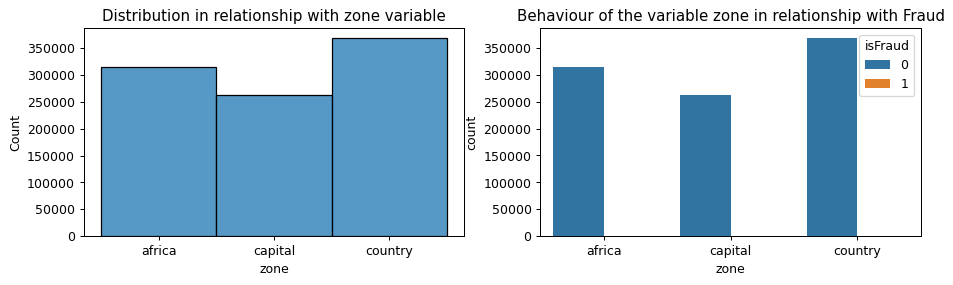

In [24]:
# Analysis of the variable zone
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.histplot(data=data, x='zone', ax=ax1, stat='count')
sns.countplot(x='zone', data=data, hue='isFraud', ax=ax2)
ax1.set_title("Distribution in relationship with zone variable")
ax2.set_title("Behaviour of the variable zone in relationship with Fraud")

In [25]:
data_noFraud=data.loc[(data['isFraud'] == 0),['isFraud','zone']].groupby('zone').count().reset_index().set_axis(["zone","noFraud"],axis=1)
data_yesFraud=data.loc[(data['isFraud'] == 1),['isFraud','zone']].groupby('zone').count().reset_index().set_axis(["zone","yesFraud"],axis=1)
data_Fraud_zone=pd.merge(data_noFraud,data_yesFraud, how= "inner", on=["zone"])
data_Fraud_zone

,zone,noFraud,yesFraud
0,africa,313670,356
1,capital,261845,286
2,country,367617,387


In the table created we can observe that there aren´t more difference in the zone where realized the transaction, because probably this variable don´t have much impact in the later analysis.  

We can observe that the gender, race, device and zone variables have null values but they haven´t more impact in the fraud. 

## 8. Study of Correlation

### -Correlation Matrix 

In [26]:
data.corr()

,step,amount,connection_time,oldbalanceOrg,age,newbalanceOrig,user_number,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud
step,1.000000,-0.025996,0.001068,-0.006782,0.000201,-0.007182,-0.000356,-0.000140,-0.001313,-0.002251,-0.019502,0.045030
amount,-0.025996,1.000000,0.001755,0.004864,0.000076,-0.001132,0.001476,0.000579,-0.000490,0.215562,0.311942,0.128862
connection_time,0.001068,0.001755,1.000000,-0.001279,0.001739,-0.001342,-0.000450,0.000466,-0.520283,-0.000199,-0.000029,0.000290
oldbalanceOrg,-0.006782,0.004864,-0.001279,1.000000,0.000155,0.999050,0.000379,-0.001799,0.000091,0.093305,0.064050,0.003829
age,0.000201,0.000076,0.001739,0.000155,1.000000,0.000119,0.001168,0.000634,0.000363,0.000441,0.000377,0.000551
newbalanceOrig,-0.007182,-0.001132,-0.001342,0.999050,0.000119,1.000000,0.000351,-0.001844,0.000105,0.095179,0.063722,-0.009438
user_number,-0.000356,0.001476,-0.000450,0.000379,0.001168,0.000351,1.000000,-0.000554,-0.001604,-0.001038,-0.000588,-0.000821
user_connections,-0.000140,0.000579,0.000466,-0.001799,0.000634,-0.001844,-0.000554,1.000000,-0.000040,0.000902,0.001160,0.000764
security_alert,-0.001313,-0.000490,-0.520283,0.000091,0.000363,0.000105,-0.001604,-0.000040,1.000000,0.000824,0.000650,0.000265
oldbalanceDest,-0.002251,0.215562,-0.000199,0.093305,0.000441,0.095179,-0.001038,0.000902,0.000824,1.000000,0.978401,-0.007553


### -Heatmap 

<AxesSubplot:>

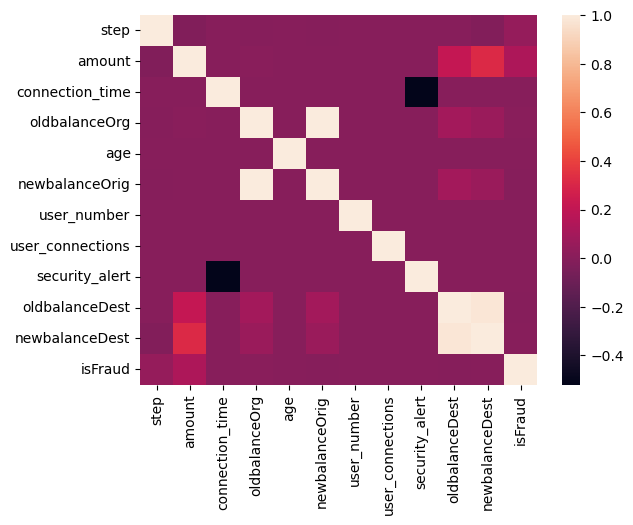

In [27]:
sns.heatmap(data.corr())

### -Spearman

In [28]:
corr = data[list_numerical_variables].corr('pearson')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1)
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.6]

,level_0,level_1,correlation
20,newbalanceOrig,oldbalanceOrg,0.999050
34,newbalanceDest,oldbalanceDest,0.978401


In [29]:
data_continous_variables = data [['step','connection_time','age', 'user_number', 
                                  'user_connections', 'amount','oldbalanceOrg', 
                                  'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
data_continous_variables.head()

,step,connection_time,age,user_number,user_connections,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,0.140039,85,138,5,9839.64,170136.0,160296.36,0.0,0.0
1,1,0.496890,57,909,1,1864.28,21249.0,19384.72,0.0,0.0
2,1,0.781150,66,2569,10,181.00,181.0,0.00,0.0,0.0
3,1,0.565068,31,1787,3,181.00,181.0,0.00,21182.0,0.0
4,1,0.517114,90,3997,8,11668.14,41554.0,29885.86,0.0,0.0


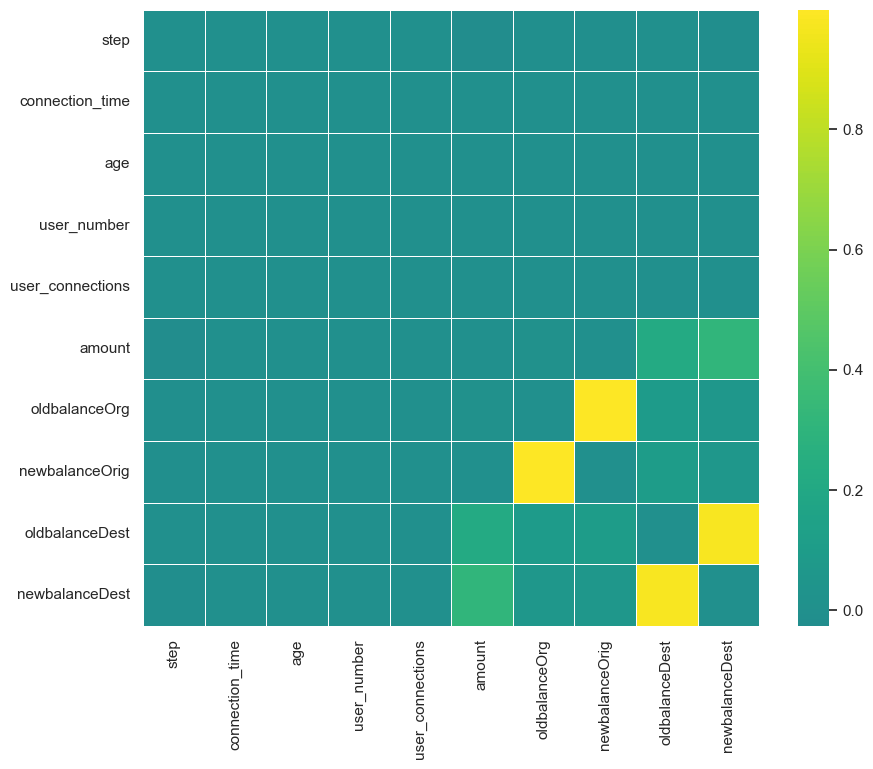

0

In [30]:
get_corr_matrix(dataset = data_continous_variables,
                metodo = 'pearson', size_figure = [10,8])

# 9. Save the created Dataset

In [31]:
path = '../data/processed/'
new_file = 'new_dataset_fraud.parquet'

data.to_parquet(path+new_file)

# 10. Conclusions

To finish the study is necessary talk about this dataset, first of all, is **completely unbalanced**. Since our target variable, isFraud, being the not fraud variables in the **99.89% of the cases**. 

There are two columns that they are **gender and race**, that we drop it because is a **sensitive topic** in relation and compliance with **the law of the European Union (GDPR)**.

In this dataset we observe there are **some outliers**, in the **four columns with more correlationship**, **newbalanceOrig-oldbalanceOrig** and **newbalanceDest-oldbalanceDest**, and also in the **column amount**.

It´s probably that the variables nameOrig and nameDest will be transform, because the letters C and M, where **C matches with client and the letter M with merchant**, the number that follows the letter is an identification. 

For the variable **transaction type**, we have learn that **only Transfers and Cash outs** are the ones that **can be Fraud**.